In [42]:
from itertools import combinations
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from pandas._typing import FrameOrSeries

df = pd.read_csv('stud_math.csv')

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)

#Описание датасета
# 1 school — аббревиатура школы, в которой учится ученик
# 2 sex — пол ученика ('F' - женский, 'M' - мужской)
# 3 age — возраст ученика (от 15 до 22)
# 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
# 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
# 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
# 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
# 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
# 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
# 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
# 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
# 16 schoolsup — дополнительная образовательная поддержка (yes или no)
# 17 famsup — семейная образовательная поддержка (yes или no)
# 18 paid — дополнительные платные занятия по математике (yes или no)
# 19 activities — дополнительные внеучебные занятия (yes или no)
# 20 nursery — посещал детский сад (yes или no)
# 21 higher — хочет получить высшее образование (yes или no)
# 22 internet — наличие интернета дома (yes или no)
# 23 romantic — в романтических отношениях (yes или no)
# 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
# 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
# 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
# 28 absences — количество пропущенных занятий
# 29 score — баллы по госэкзамену по математике

In [38]:
#Классифицируем переменные
variable_types = {}
variable_types['quantitative'] = ['age','absences','score']
variable_types['nominative']   = [column for column in df.columns if column not in variable_types['quantitative']]
variable_types['binary']       = ['sex','pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
variable_types['categorical']  = [column for column in variable_types['nominative'] if column not in variable_types['binary']]
variable_types['ranking']      = ['traveltime','studytime','freetime','goout','health']


In [43]:
#Добавим класс обертку, перегрузим, добавим новые методы
class DataFrame(pd.DataFrame):

    def describe(self: FrameOrSeries, percentiles=None, include=None, exclude=None) -> FrameOrSeries:

        description = super().describe(percentiles=percentiles,include=include,exclude=exclude)
        rows_count = len(self)

        def add_indicators(column):
            iqr = column['75%']-column['25%']
            bottom_bound = column['25%']-1.5*iqr
            top_bound = column['75%']+1.5*iqr

            description.loc['nan_count', column.name] = rows_count - column['count']
            description.loc['iqr', column.name] = iqr
            description.loc['bottom_bound', column.name] = bottom_bound
            description.loc['out_bottom_bound', column.name] = (self[column.name]<bottom_bound).sum()\
                if not np.isnan(bottom_bound) else np.NAN
            description.loc['top_bound', column.name] = top_bound
            description.loc['out_top_bound', column.name] = (self[column.name]>top_bound).sum()\
                if not np.isnan(top_bound) else np.NAN
            # print((self[column.name]<bottom_bound).sum())

        description.apply(add_indicators,axis=0)

        return  description

    def get_stat_dif(self,x,y,pvalue,n=None):

        result = []

        #первые 10 наиболее частых значений
        cols = self[x].value_counts().index[:len(self) if not n else n]

        #сочетания значений по 2 из 10, 45 сочетаний
        combinations_all = list(combinations(cols, 2))

        for comb in combinations_all:

            group1 = self[self[x]==comb[0]][y]
            group2 = self[self[x]==comb[1]][y]

            if ttest_ind(group1,group2).pvalue <= pvalue/len(combinations_all):
                result.append(x)
                break

        return result

    def transform_default_names(self):

        pattern1 = re.compile('\s+')
        pattern2 = re.compile('\W*')
        columns_names = {}

        for column in self.columns:
            columns_names[column] = column
            columns_names[column] = columns_names[column].lower()
            columns_names[column] = re.sub(pattern1,'_',columns_names[column])
            columns_names[column] = re.sub(pattern2,'',columns_names[column])

        self.rename(columns=columns_names,inplace=True)

df = DataFrame(df)

In [44]:
#Переименуем колонки по умолчанию
df.transform_default_names()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
count,395,395,395.000000,378,368,350,392.000000,371.000000,376,359,378,364,367.000000,388.000000,373.000000,386,356,355,381,379,388.000000,375,361,364,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,4,3,NaN,NaN,NaN,2,2,2,2,2,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,course,mother,NaN,NaN,NaN,no,yes,no,yes,yes,NaN,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN
freq,349,208,NaN,295,261,314,NaN,NaN,133,197,137,250,NaN,NaN,NaN,335,219,200,195,300,NaN,356,305,240,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.750000,2.614555,NaN,NaN,NaN,NaN,1.438692,2.038660,0.337802,NaN,NaN,NaN,NaN,NaN,-6.115979,NaN,NaN,NaN,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.098127,2.228732,NaN,NaN,NaN,NaN,0.694181,0.842078,0.743135,NaN,NaN,NaN,NaN,NaN,2.526235,NaN,NaN,NaN,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-12.000000,NaN,NaN,NaN,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,NaN,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000


In [ ]:
df = DataFrame(df)
df.describe(include='all')

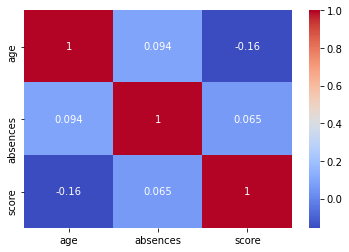

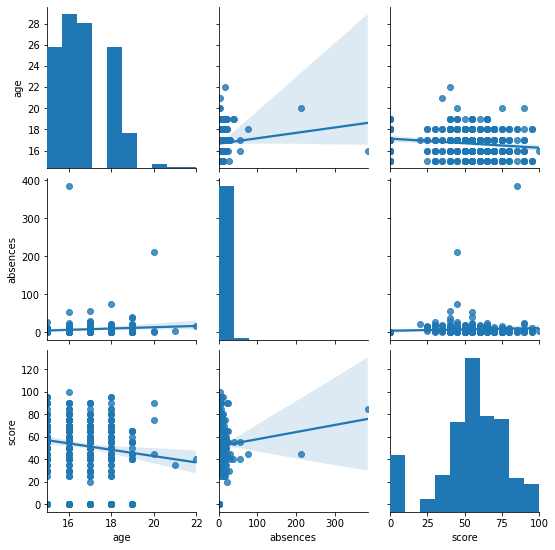

In [40]:
#Корреляционный анализ
sns.heatmap(df[variable_types['quantitative']].corr(),annot=True,cmap='coolwarm')
sns.pairplot(df[variable_types['quantitative']],kind='reg')

In [41]:
#Поиск статистически значимых различий
for x in variable_types['nominative']:
    df.get_stat_dif(x,'score',0.05,10)

TypeError: Cannot perform 'rand_' with a dtyped [bool] array and scalar of type [bool]